# Data loading

In [1]:
import copy
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
jar1 = pd.read_csv('fuel_swelling_20240109.txt', sep=' ')
columns_drop = ['%eval_id', 'interface', 'FD1', 'FD2', 'FD3', 'fuel_swelling2', 'fuel_swelling3']
jar1.drop(columns=columns_drop, inplace=True)

jar2 = pd.read_csv('fuel_swelling_20240109.txt', sep=' ')
columns_drop = ['%eval_id', 'interface', 'FD1', 'FD2', 'FD3', 'fuel_swelling1', 'fuel_swelling3']
jar2.drop(columns=columns_drop, inplace=True)

jar3 = pd.read_csv('fuel_swelling_20240109.txt', sep=' ')
columns_drop = ['%eval_id', 'interface', 'FD1', 'FD2', 'FD3', 'fuel_swelling1', 'fuel_swelling2']
jar3.drop(columns=columns_drop, inplace=True)

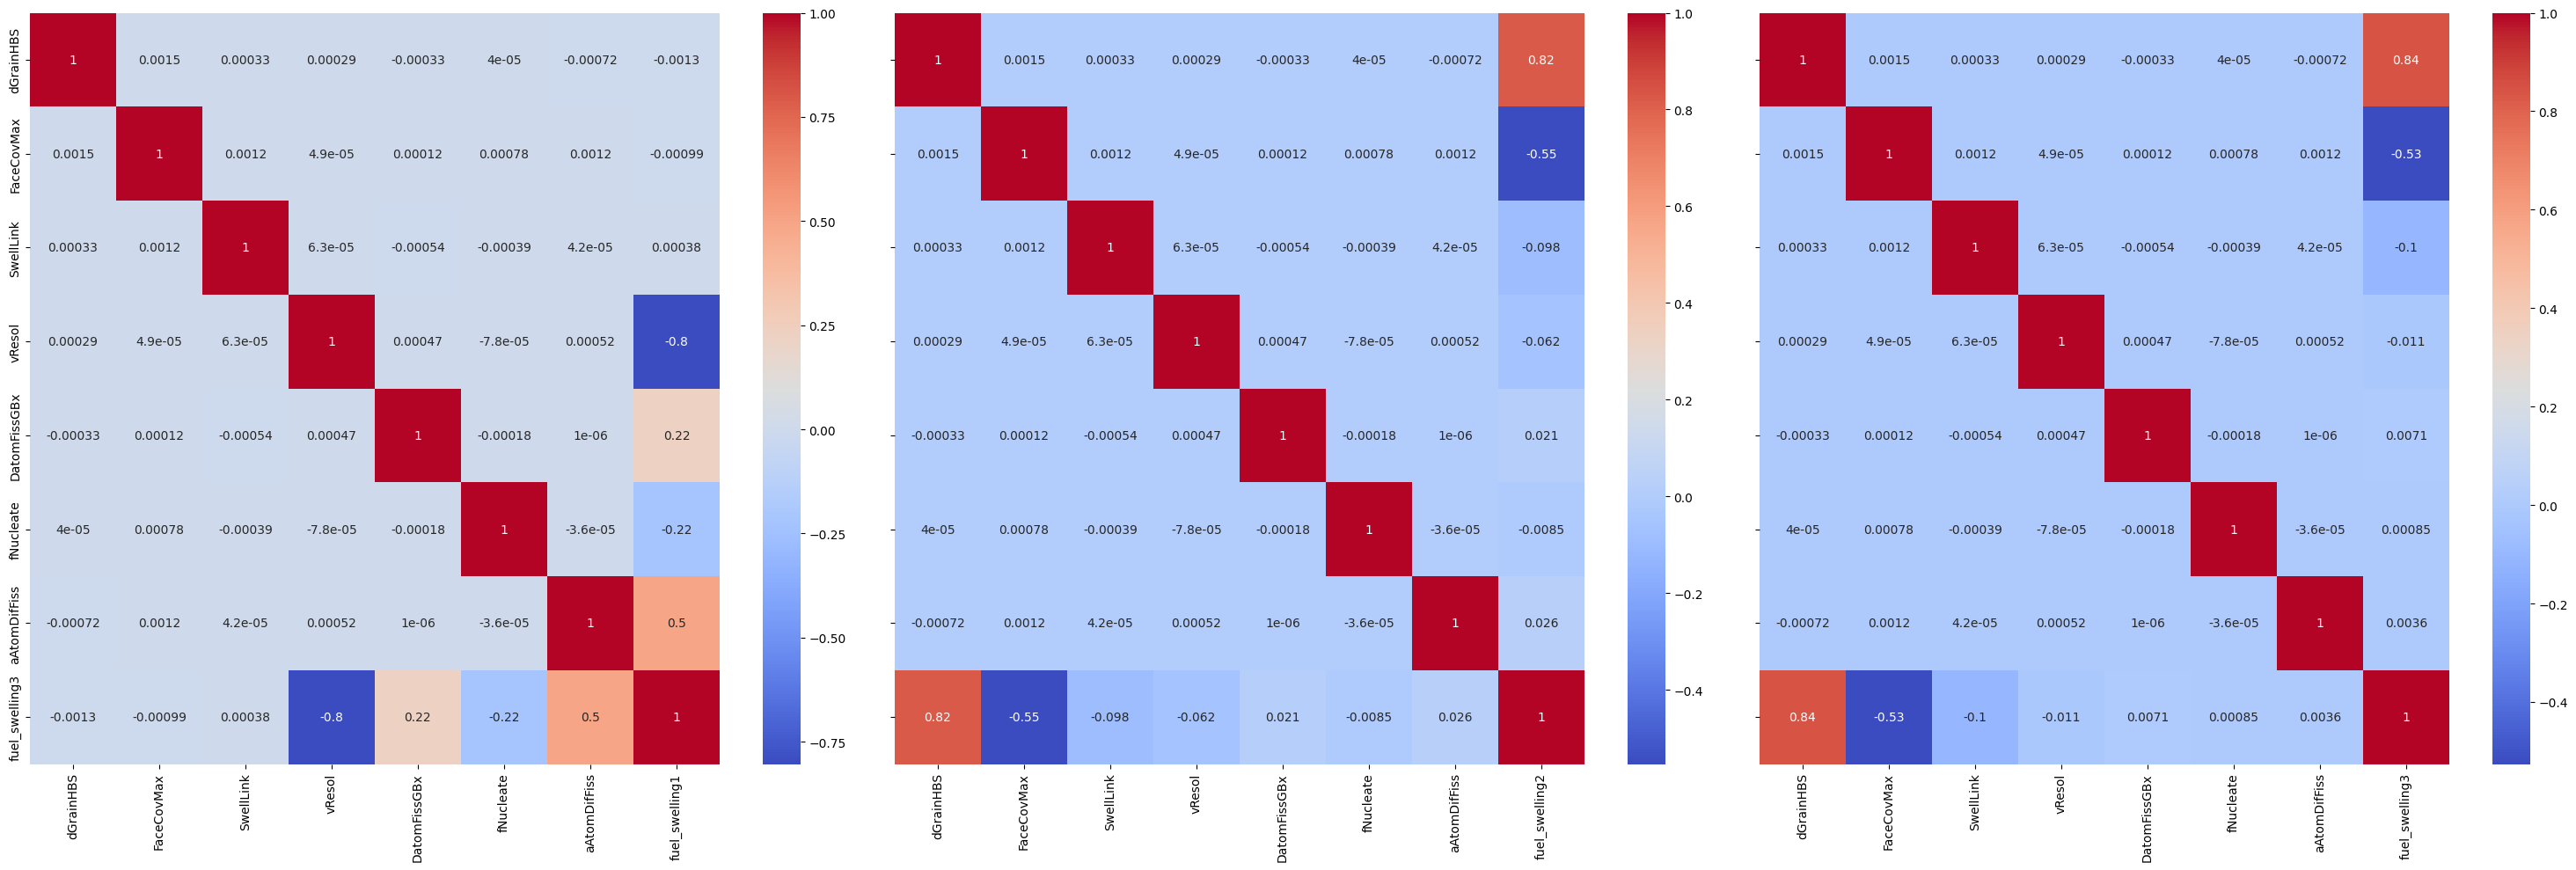

In [3]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(30, 10))
jar = [jar1, jar2, jar3]

for i, ax in enumerate(axes.flatten()):
    sns.heatmap(jar[i].corr(), ax=ax, annot=True, cmap='coolwarm')

plt.tight_layout()
plt.show()

# Linear

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [5]:
feat_ind = list(range(7))
features = jar1.iloc[:, feat_ind]
xscaler = StandardScaler()
X = xscaler.fit_transform(features)

In [6]:
y1 = jar1['fuel_swelling1']
y2 = jar2['fuel_swelling2']
y3 = jar3['fuel_swelling3']

In [7]:
reg1 = LinearRegression().fit(X, y1)
reg2 = LinearRegression().fit(X, y2)
reg3 = LinearRegression().fit(X, y3)

In [8]:
print(reg1.score(X, y1),
      reg2.score(X, y2),
      reg3.score(X, y3))

0.9946161178609967 0.996650936980607 0.996884663293091


In [9]:
print(reg1.coef_,
      reg2.coef_,
      reg3.coef_)

[-3.23565226e-05 -7.11882241e-05  2.27050870e-05 -4.15102052e-02
  1.14404072e-02 -1.15880044e-02  2.57878512e-02] [ 0.76047    -0.51284383 -0.09022062 -0.05712147  0.02001058 -0.00750317
  0.02511336] [ 2.82724374 -1.77142238 -0.35113877 -0.03660669  0.02490697  0.00399536
  0.01631501]


# MCMC

In [10]:
def target_dist(x, mu, sig):
    return np.exp(-0.5 * ((x-mu)/sig)**2)

In [11]:
def candidate_dist(x, sig):
    return np.random.normal(x, sig)

In [98]:
def mod_mcmc_sampler(num_param, num_samples, initial_state, proposal_sigma, models):
    samples = [initial_state]

    for ii in range(num_samples):
        current_state = samples[-1]

        mus = [8.4, 21, 45]
        sigs = [0.025, 0.5, 2]
        #sigs = [0.005, 0.05, 1]

        arr = [0, 1, 2]            # [0,1,2] -> [2,4,6] F_d
        fd_ind = random.choice(arr)
        
        mu = mus[fd_ind]
        sig = sigs[fd_ind]
        model = models[fd_ind]

        for jj in range(num_param):
            current_p = current_state[jj]
            proposed_p = 6              # just to start the loop
            while (abs(proposed_p) > 3):
                proposed_p = candidate_dist(current_p, proposal_sigma)
            #proposed_p = candidate_dist(current_p, proposal_sigma)

            proposed_state = copy.deepcopy(current_state)
            proposed_state[jj] = proposed_p
            theta1 = model.predict([[*current_state]])[0]
            theta2 = model.predict([[*proposed_state]])[0]

            #acceptance_ratio = target_dist(proposed_state) / target_dist(current_state)
            acceptance_ratio = target_dist(theta2, mu, sig) / target_dist(theta1, mu, sig)

            if np.random.rand() < acceptance_ratio:
                current_state = proposed_state

        samples.append(current_state)

    return np.array(samples)

In [101]:
regs = [reg1, reg2, reg3]
hey = mod_mcmc_sampler(7, 20000, np.zeros(7), 0.2, regs)

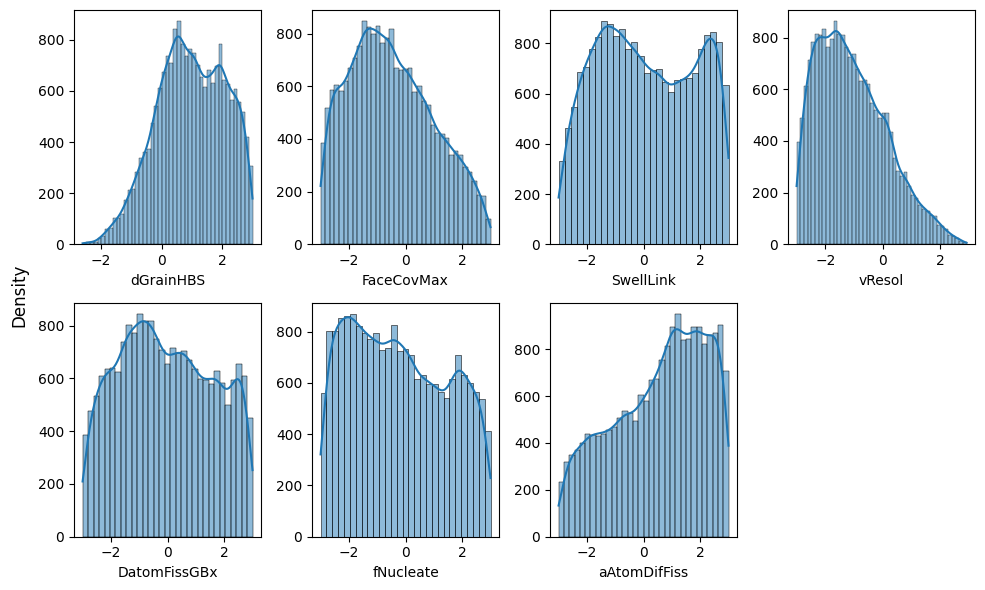

In [102]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 6))

for i, ax in enumerate(axes.flatten()[:-1]):
    sns.histplot(hey[:,i], ax=ax, kde=True)
    ax.set_xlabel(jar1.columns[i])
    ax.set_ylabel('')

fig.delaxes(axes[1,3])
fig.supylabel('Density')
plt.tight_layout()
plt.show()

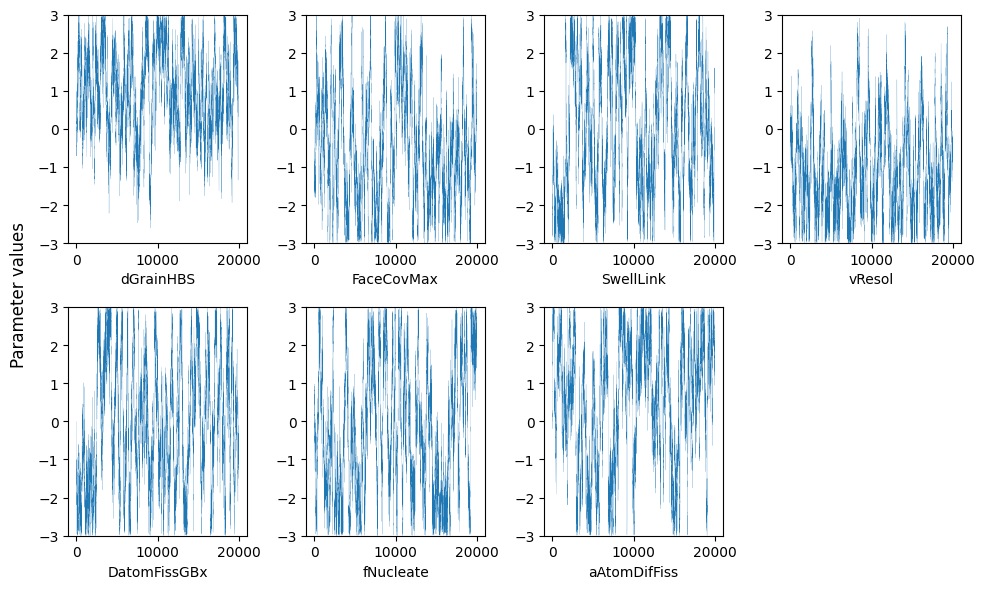

In [103]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 6))

for i, ax in enumerate(axes.flatten()[:-1]):
    ax.plot(hey[:,i], lw=0.1)
    ax.set_xlabel(jar1.columns[i])
    ax.set_ylim([-3, 3])

fig.delaxes(axes[1,3])
fig.supylabel('Parameter values')
plt.tight_layout()
plt.show()

# Extra

In [93]:
len(hey)

100001

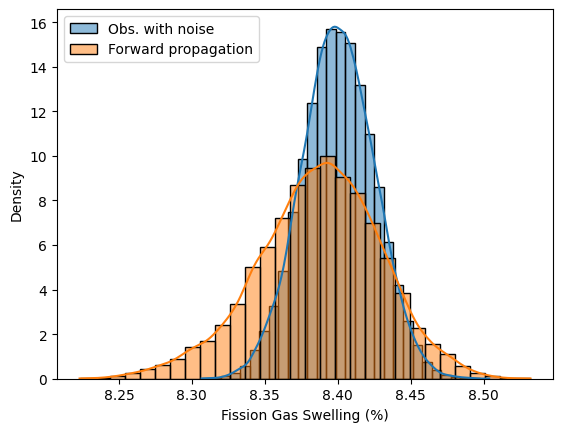

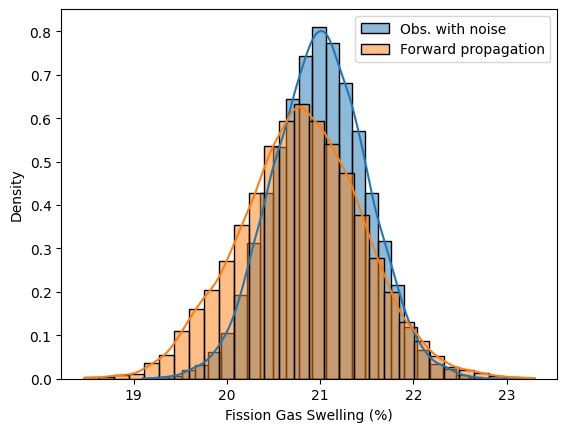

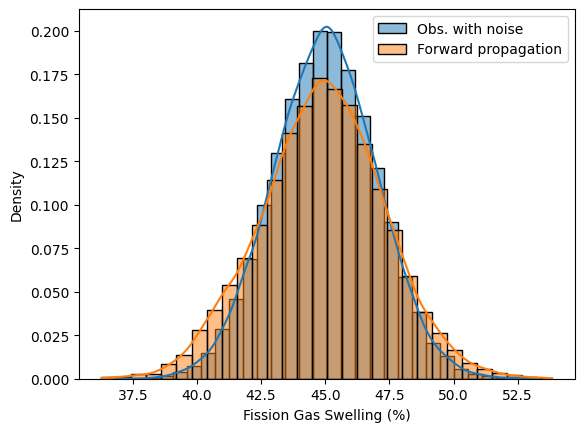

In [110]:
for mod, mu, sig in zip([reg1, reg2, reg3], [8.4, 21, 45], [0.025, 0.5, 2]):
    orig = []
    res = []
    for i in range(20000):
        res.append(mod.predict([hey[-i]])[0])
        c = np.random.normal(mu, sig)
        orig.append(c)
        
    sns.histplot(orig, kde=True, bins=30, ec='k', stat='density', label='Obs. with noise')
    sns.histplot(res, kde=True, bins=30, ec='k', stat='density', label='Forward propagation')
    
    plt.xlabel('Fission Gas Swelling (%)')
    plt.legend()
    plt.show()

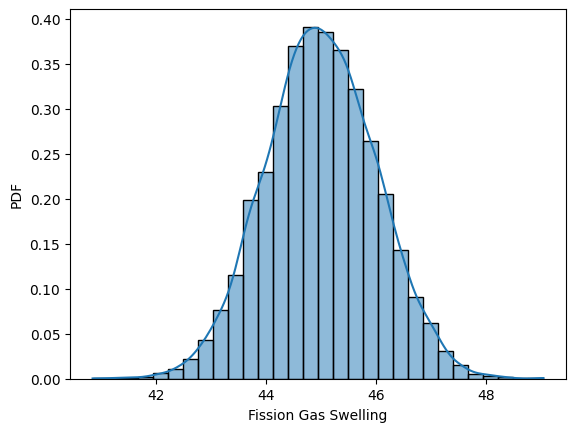

In [81]:
asdf = []
for i in range(10000):
    asdf.append(np.random.normal(45, 1))
    
sns.histplot(asdf, kde=True, bins=30, ec='k', stat='density')

plt.xlabel('Fission Gas Swelling')
plt.ylabel('PDF')
plt.show()

In [16]:
len(hey)

50001

In [21]:
print(hey[1000])

[ 2.60763422  3.61108464 -2.17911117  1.21993281  1.3543427  -1.05505342
  2.58940225]


In [29]:
df = pd.DataFrame(hey)
df.columns = jar1.columns[:7]

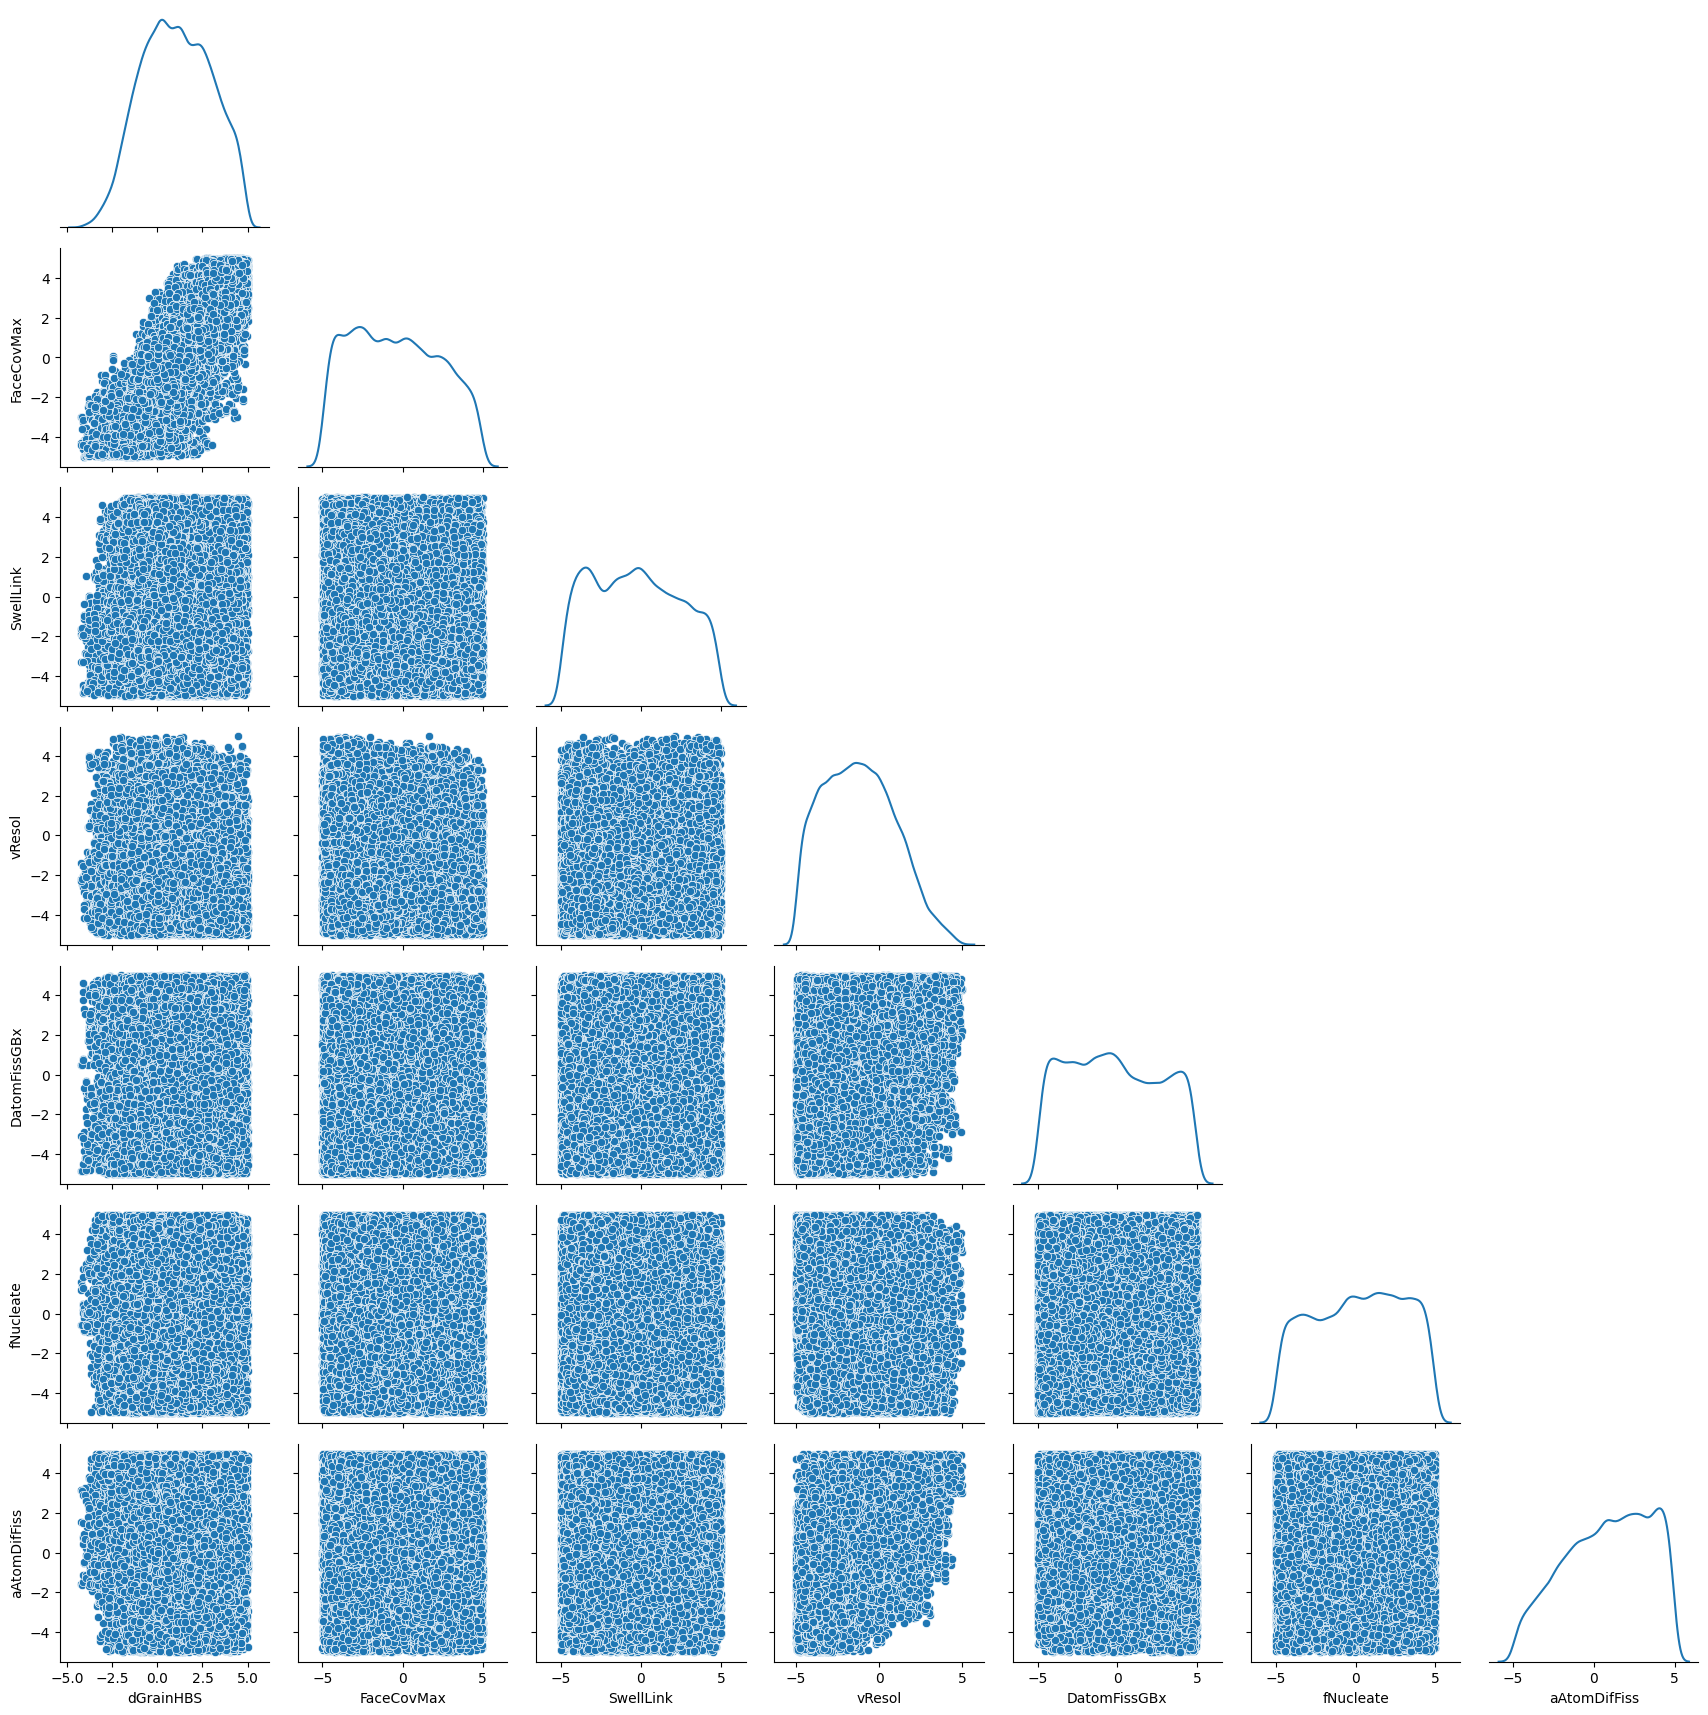

In [31]:
pp = sns.PairGrid(df, corner=True)
pp.map_diag(sns.kdeplot)
pp.map_lower(sns.scatterplot)